# Initialization

In [1]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import sys, os, re, csv
import seaborn
import re
seaborn.set(font_scale=2)
seaborn.set_style("ticks")
clrs = seaborn.color_palette(n_colors=7)

# stim1 is left stim0 is right

In [2]:
# Get variables from plot notebook

%store -r savePath
%store -r path
%store -r kpTags
%store -r rmTags

Select the folder to analyse:

In [3]:
# Data Path
try:
    savePath
except NameError:
    savePath = "D:/King_lab/FSH_projects/Hanna_2017/"
    # savePath = "F:/King_lab/Pitch/"
    # savePath = "D:/King_lab/FSH_projects/Hanna_2017/"
try:
    path
except NameError:
    # path = '/home/rastamouse/Documents/Data/behaviour_data/mousewise/Tyrion/'
    # path = 'C:/Users/Quentin/Dropbox/Hannah2017/Data_win/Data/Fernand/'
    path = 'C:/Users/dpag0680/Dropbox/Hannah2017/Data_win/Fernand/'
try:
    kpTags
except NameError:
    kpTags = ["08-08", "08-09", "08-10"]
try:
    rmTags
except NameError:
    rmTags = ["ignore", "habituation", "training"]

Mname = path.split("/")
if Mname[-1] == "":
    Mname = Mname[-2]
else:
    Mname = Mname[-1]

# path = 'D:/Work/Data/Hannah2017/Data/Dany/'
# path = '/home/rastamouse/Downloads/Hannah2017/Data/Gendry/'
fileListOr = (os.listdir(path))
# print("In folder: "+ str(len(fileListOr)) + " items")
# [print(t) for t in fileListOr]

# filter list
fileList = []
# kpTags = []
if len(kpTags)>0:
    for t in kpTags:
        fileList = fileList + ([x for x in fileListOr if (t in x)]) # keep only the rmTags from list
else:
    fileList = fileListOr
    
for t in rmTags:
    fileList = [x for x in fileList if not (t in x)] # remove the rmTags from list
    

fileList = np.array(fileList)[np.argsort([re.findall(".*_2017(.*)",i)[0] for i in fileList ])] # Order files

# print()
# print("After Selection: " + str(len(fileList)) + " items")
# print(fileList)

#DateList for plotting purpose
dateList = []
for f in fileList:
#     print(fileList[0])
    match = re.search(r'\d{4}-\d{2}-\d{2}', f)
    dateList.append(match.group(0))
    

In [4]:
# Constants
intervalDur = 10

In [5]:
# Functions
def calcMI(respMat):
    eps = np.finfo(float).eps # Bug for log2(0)
    nRow = respMat.shape[0]
    nCol = respMat.shape[1]
    sumX = respMat.sum(axis=0)
    sumY = respMat.sum(axis=1)
    sumX = sumX.flatten()
    sumY = sumY.flatten()
    nTot = respMat.sum()
    MI = 0
    for x in range(nRow):
        for y in range(nCol):
            pxy = respMat[x, y]/nTot
            px = sumY[0][0,x]/sumY.sum()
            py = sumX[0][0,y]/sumX.sum()
            MI = MI + (pxy * np.log2(eps + pxy/(px * py)))
    return MI

def sig_test(p1,n1,p2,n2):
    top = p1 - p2
    phat = (n1*p1 + n2*p2)/(n1+n2)
    bot = np.sqrt(phat*(1-phat)*((1/n1)+(1/n2)))
    return top/bot

# Data Importation

In [6]:
rew_sides = []
rew_t = [] 
stim_type = [] 
stim_t = [] 
lick_t = []
lick_d = []

licktC = []
licktR = []
licktL = []

allTrials = []
nTest = 0
for idx,fName in enumerate(fileList):
    f = csv.reader(open(path + fName))
    harmonic_idxs = []

    rews = []
    stims = []
    licks = []
    for row in f:

        for col in row:
            if len(re.findall("rewList:", col))>0:
                t = re.findall("rewList:(.*)", col)[0]
                if t!='':
                    tmprews = t.split("-")
                    tmprews = [x for x in tmprews if not ("C" in x)] # remove the "C" rewards from list
                    rews = rews + tmprews

            if len(re.findall("sndList:", col))>0:
                t = re.findall("sndList:(.*)", col)[0]

                if t!='':
                    stims = stims + t.split("-")

            if len(re.findall("LickList:", col))>0:
                t = re.findall("LickList:(.*)", col)[0]
                if t!='':
                    t_sides = ["L" if "L" in i else "R" if "R" in i else "C" for i in t.split("-")]
                    t_times = [float(re.findall("([0-9]{1,5}.[0-9]{1,5})[R,L,C]",i)[0]) for i in t.split("-")]
                    t_ = [[i,j] for i,j in zip(t_times,t_sides)]
                    licks = licks + t_

    rew_sides.append(np.array([re.findall("[0-9]{1,5}.{0,2}[0-9]{0,5}([A-z]*)",i)[0] for i in rews]))
    rew_t.append(np.array([float(re.findall("([0-9]{1,5}.{0,2}[0-9]{0,5})[A-z]*",i)[0]) for i in rews]))
    stim_type.append(np.array([int(re.findall("[0-9]{1,5}.{0,2}[0-9]{0,5}([0,1])",i)[0]) for i in stims]))
    stim_t.append(np.array([float(re.findall("([0-9]{1,5}.{0,2}[0-9]{0,5})[A-z]*",i)[0]) for i in stims]))
    lick_t.append(np.array([i[0] for i in licks]))
    lick_d.append(np.array([i[1] for i in licks]))
    
    licktC.append(np.array(lick_t[idx])[np.where(np.array(licks)=='C')[0]])
    licktR.append(np.array(lick_t[idx])[np.where(np.array(licks)=='R')[0]])
    licktL.append(np.array(lick_t[idx])[np.where(np.array(licks)=='L')[0]])
    
    
#     harmonic_idxs = np.where(np.array(["Harm" in i for i in stims]))[0]
    harmonic_idxs = np.where(np.array(["kHz" in i for i in stims]))[0]
    
    # Exclude correction trials
#     print(stim_type)
    prevHit = True
    for idxS,c in enumerate(stim_type[idx]):
        hit = False
        corr = False
#         print(stim_t[idx][idxS])
        # Lick dir
        RL = licktR[idx][np.where((licktR[idx]>=stim_t[idx][idxS]) * (licktR[idx] <= (stim_t[idx][idxS]+intervalDur)))[0]]
        LL = licktL[idx][np.where((licktL[idx]>=stim_t[idx][idxS]) * (licktL[idx] <= (stim_t[idx][idxS]+intervalDur)))[0]]

        # Hit/Miss
        if c == 0:
            if ((len(RL)>0) and (len(LL)>0) and (RL[0] < LL[0])) or ((len(RL)>0) and (len(LL)==0)):
                hit = True
        else:
            if ((len(RL)>0) and (len(LL)>0) and (RL[0] > LL[0])) or ((len(LL)>0) and (len(RL)==0)):
                hit = True

        #Corr trials
        if not prevHit:
            corr = True
            
        isTrial =  sum(harmonic_idxs == idxS)
    
        if not isTrial:
            stimID = 'NA'
        else:
            stimID = stims[idxS].split("+")[1]
            nTest = nTest+1
        
#         trial = ['stim', c, 'stim time', stim_t[idx], 'hit', hit, 'correction trial', corr, 'lickR', RL, 'lickL', LL, 'isTrial',isTrial, 'TrialID', stimID]
#         print([isTrial, stimID])
        # print(stim_t[idx][idxS])
        trial = ['stim', c, 'stim time', stim_t[idx][idxS], 'hit', hit, 'correction trial', corr, 
                 'lickR', RL, 'lickL', LL, 'isTrial',isTrial, 'TrialID', stimID, 'session IDX', idx]
        allTrials.append(trial)
        prevHit = hit

        
print("Total number of trials: " + str(len(allTrials)))
print("Total number of test trials: " + str(nTest))
# print(len(rew_sides))
# print((rew_sides))
# print(len(rew_t))
# print((rew_t))
# print(len(stim_type))
# print((stim_type))
# print(len(stim_t))
# print((stim_t))
# print(len(lick_t))
# print((lick_t))
# print(len(lick_d))
# print((lick_d))

Total number of trials: 690
Total number of test trials: 226


In [7]:
# for i in range(50):
#     print(allTrials[-i])
    

# Session overview

In [8]:
for idx,name in enumerate(fileList):
    print([idx, name])

[0, 'Margaery_mice_trial2_2017-08-12 12-54-58']
[1, 'Margaery_mice_trial2_2017-08-12 13-26-44']


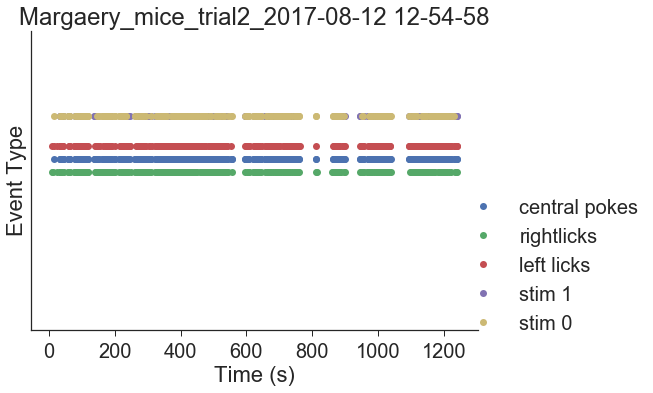

In [9]:
sessionidx = []

licktC = []; licktR = []; licktL = []

for idx,f in enumerate(fileList):
    licktC.append(np.array(lick_t[idx])[np.where(np.array(lick_d[idx])=='C')[0]])
    licktR.append(np.array(lick_t[idx])[np.where(np.array(lick_d[idx])=='R')[0]])
    licktL.append(np.array(lick_t[idx])[np.where(np.array(lick_d[idx])=='L')[0]])

# Plots
for s in sessionidx:
    plt.figure()
    plt.plot(licktC[s],[1.5]*len(licktC[s]),'o',label='central pokes')
    plt.plot(licktR[s],[1.35]*len(licktR[s]),'o',label='rightlicks')
    plt.plot(licktL[s],[1.65]*len(licktL[s]),'o',label='left licks')
    plt.plot(stim_t[s][np.where(stim_type[s]==1)[0]],
             [2]*len(np.where(stim_type[s]==1)[0]),'o',label='stim 1')
    plt.plot(stim_t[s][np.where(stim_type[s]==0)[0]],
             [2]*len(np.where(stim_type[s]==0)[0]),'o',label='stim 0')

    plt.ylim(-.5,3)
    plt.yticks([])
    plt.xlabel("Time (s)")
    plt.ylabel("Event Type")
    plt.legend(bbox_to_anchor=(1.4,.5))
    plt.title(fileList[s])
    #plt.xlim(300,600)
    seaborn.despine()

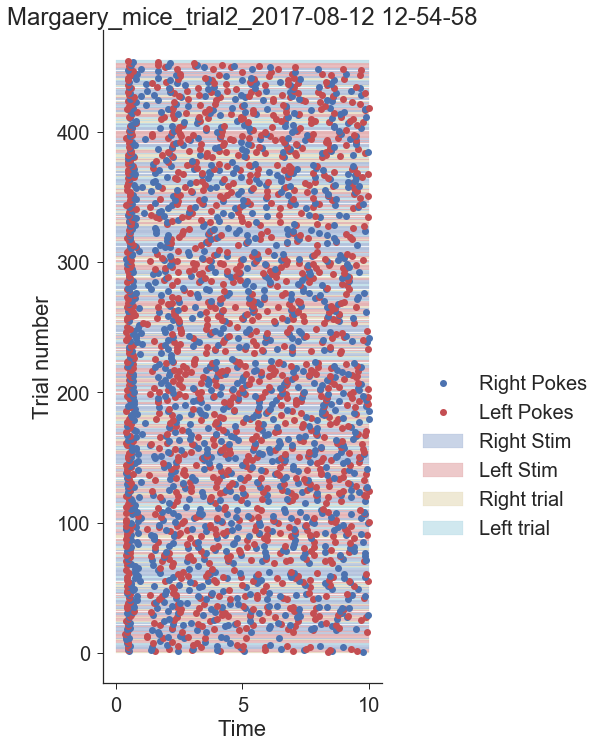

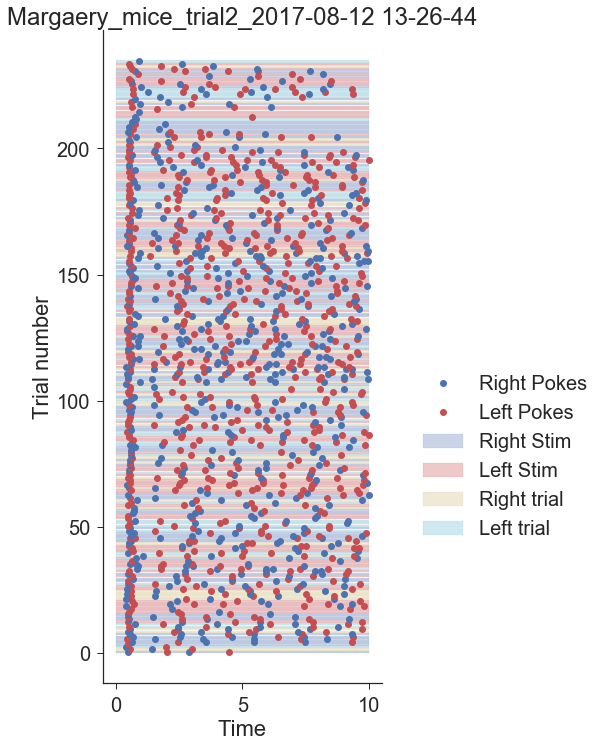

In [10]:
# Align the licks to the central poke. 0 : Central poke, grey dots: Right licks, red dots: Left licks.
# Well trained animals should have a massed number of licks after 0, to the proper direction
# Color on 0 indicates target, red for left, grey for right
#print(licktC)
#print(licktR)
sessionidx = []


T = [i[17] for i in allTrials]
for idx in sessionidx:
    localTrial = []
    tIdx = [i for i,x in enumerate(T) if x == idx]
    for i in tIdx:
        localTrial.append(allTrials[i])


    plt.figure(figsize=(5,12))
    for count,c in enumerate(localTrial):
        #print(count)
        RL = c[9]
        LL = c[11]
        plt.plot(RL-c[3],[count+.5]*len(RL),'o',color=clrs[0])
        plt.plot(LL-c[3],[count+.5]*len(LL),'o',color=clrs[2],)
        if c[1]==0 and not c[13]:
            plt.fill_between([0,intervalDur],count,count+.95,color=clrs[0],alpha=.3)
        elif c[1]==1 and not c[13]:
            plt.fill_between([0,intervalDur],count,count+.95,color=clrs[2],alpha=.3)
        elif c[1]==0 and c[13]:
            plt.fill_between([0,intervalDur],count,count+.95,color=clrs[4],alpha=.3)
        elif c[1]==1 and c[13]:
            plt.fill_between([0,intervalDur],count,count+.95,color=clrs[5],alpha=.3)
    plt.fill_between([0,0],0,0,color=clrs[0],alpha=.3,label = 'Right Stim')
    plt.fill_between([0,0],0,0,color=clrs[2],alpha=.3,label = 'Left Stim')
    plt.fill_between([0,0],0,0,color=clrs[4],alpha=.3,label = 'Right trial')
    plt.fill_between([0,0],0,0,color=clrs[5],alpha=.3,label = 'Left trial')
    plt.plot([],[],'o',color=clrs[0],label = 'Right Pokes')
    plt.plot([],[],'o',color=clrs[2],label = 'Left Pokes')
    plt.ylabel("Trial number")
    plt.xlabel("Time")
    seaborn.despine()
    plt.legend(bbox_to_anchor=(1.8,0.5))
    plt.title(fileList[idx])
#     plt.savefig('T2TlickTimes.pdf')

#     plt.ylim(0,10)
#     plt.xlim(0,3)


# Controls

## Proportion of pokes Left vs. Right

In [11]:
# Total number of licks left vs right


ratio = []

for idx,f in enumerate(fileList):
#     print(idx)
    ratio.append(len(licktL[idx])/(len(licktR[idx])+len(licktL[idx])))
                 
plt.figure()
plt.plot(range(len(ratio)),ratio)

plt.plot([0,len(ratio)],[0.5, 0.5],color="Black")

plt.ylabel("Percentage of licks left")
plt.ylim([0, 1])

plt.savefig(savePath + Mname + '_LRpokesRatio.pdf')


## First poke latency

### Grand average

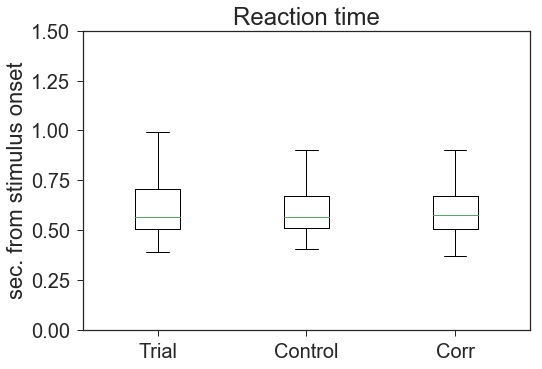

In [12]:
# trial = ['stim', c, 'stim time', stim_t[idx][idxS], 'hit', hit, 'correction trial', corr, 
#                  'lickR', RL, 'lickL', LL, 'isTrial',isTrial, 'TrialID', stimID, 'session IDX', idx]
pokeTrial = []
pokeControl = []
pokeCorr = []

for t_,trial in enumerate(allTrials):
    Dt = np.concatenate([trial[9],trial[11]])-trial[3]
    if len(Dt)>0:
        Dt = Dt.min()
        if trial[13]: #if is a trial
            pokeTrial.append(Dt)
        elif trial[7]: # Is a correction trial
            pokeCorr.append(Dt)
        else: # is a training trial
            pokeControl.append(Dt)
            
plt.figure
plt.boxplot([pokeTrial, pokeControl, pokeCorr],labels=["Trial","Control","Corr"])
plt.ylim([0,1.5])
plt.title("Reaction time")
plt.ylabel("sec. from stimulus onset")

### Over Time

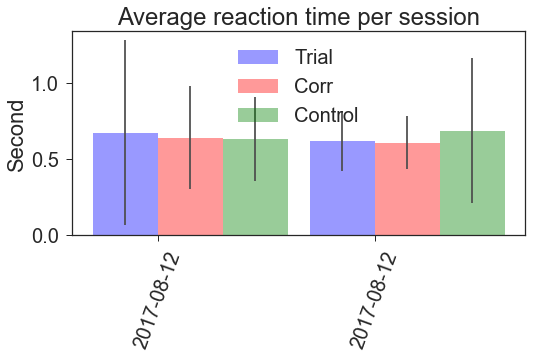

In [13]:
# trial = ['stim', c, 'stim time', stim_t[idx][idxS], 'hit', hit, 'correction trial', corr, 
#                  'lickR', RL, 'lickL', LL, 'isTrial',isTrial, 'TrialID', stimID, 'session IDX', idx]
pokeM = [[],[],[]]
pokeEr = [[],[],[]]

currentS = 0
for t_,trial in enumerate(allTrials):
    if currentS != trial[17] or t_ == len(allTrials)-1:
        pokeM[0].append(np.mean(pokeTrial))
        pokeM[1].append(np.mean(pokeCorr))
        pokeM[2].append(np.mean(pokeControl))
        pokeEr[0].append(np.std(pokeTrial))
        pokeEr[1].append(np.std(pokeCorr))
        pokeEr[2].append(np.std(pokeControl))
        pokeTrial = []
        pokeControl = []
        pokeCorr = []
        
    Dt = np.concatenate([trial[9],trial[11]])-trial[3]
    if len(Dt)>0:
        Dt = Dt.min()
        if trial[13]: #if is a trial
            pokeTrial.append(Dt)
        elif trial[7]: # Is a correction trial
            pokeCorr.append(Dt)
        else: # is a training trial
            pokeControl.append(Dt)
    currentS = trial[17]
    
    
n_groups = currentS+1
index = np.arange(n_groups)
bar_width = 0.3
opacity = 0.4
error_config = {'ecolor': '0.3'}
plt.figure
rects1 = plt.bar(index, pokeM[0], bar_width,
                 alpha=opacity,
                 color='b',
                 yerr=pokeEr[0],
                 error_kw=error_config,
                 label='Trial')

rects2 = plt.bar(index + bar_width, pokeM[1], bar_width,
                 alpha=opacity,
                 color='r',
                 yerr=pokeEr[1],
                 error_kw=error_config,
                 label='Corr')
rects3 = plt.bar(index + 2*bar_width, pokeM[2], bar_width,
                 alpha=opacity,
                 color='g',
                 yerr=pokeEr[2],
                 error_kw=error_config,
                 label='Control')


plt.ylabel('Second')
plt.title('Average reaction time per session')
# plt.xticks(index + bar_width / 2, ('A', 'B', 'C', 'D', 'E'))
plt.xticks(index + bar_width / 2, dateList,rotation=70)
plt.legend()
plt.tight_layout()


# Performance

## Performance without correction trials for Training stimuli


Margaery_mice_trial2_2017-08-12 13-26-44
Response Matrix Values: 
[[ 0.7654321   0.2345679 ]
 [ 0.42857143  0.57142857]]
MI value: 0.0871185942606
Diag : 0.668430335097
Margaery_mice_trial2_2017-08-12 13-26-44
Response Matrix Values: 
[[ 0.825  0.175]
 [ 0.32   0.68 ]]
MI value: 0.198081424585
Diag : 0.7525


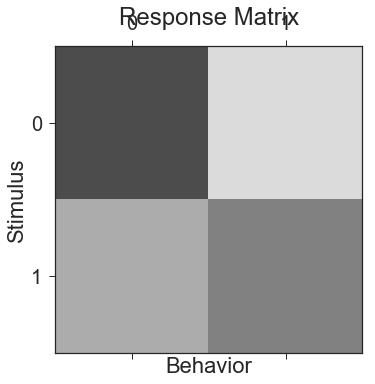

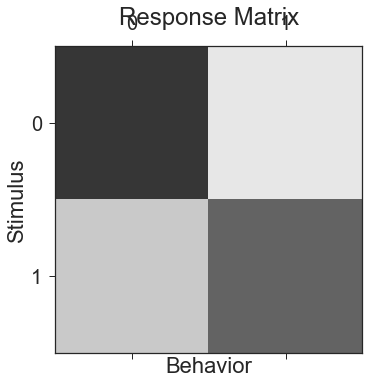

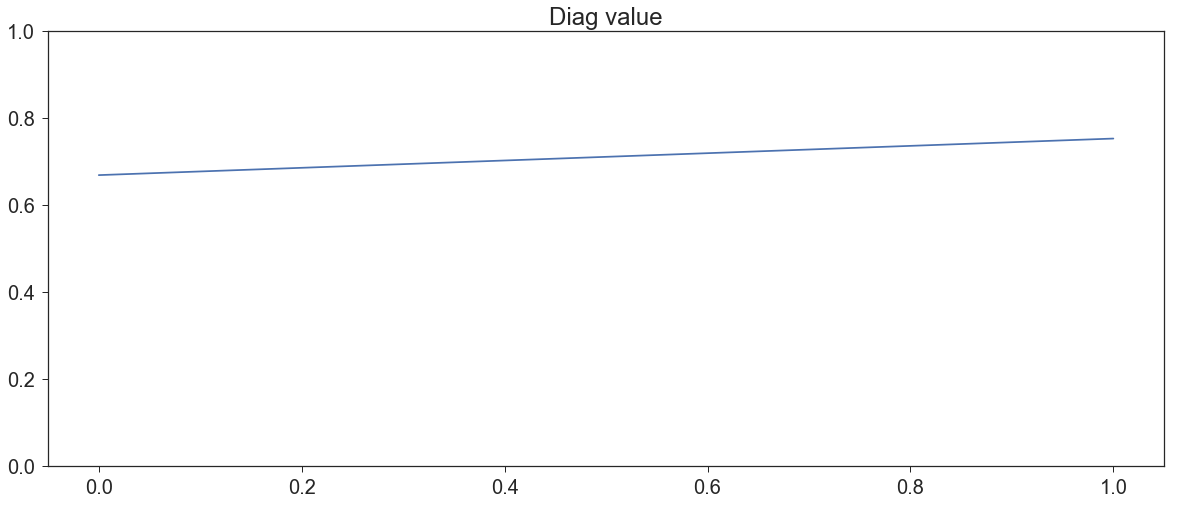

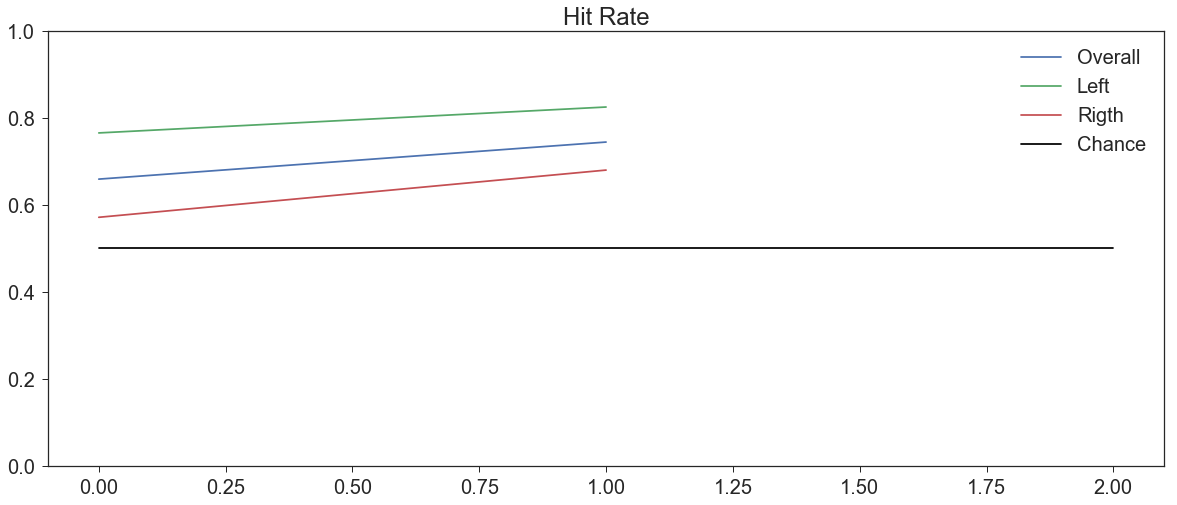

In [14]:
#  trial = ['stim', c, 'stim time', stim_t[idx][idxS], 'hit', hit,
# 'correction trial', corr, 'lickR', RL, 'lickL', LL, 'isTrial',isTrial, 'TrialID', stimID, 'session IDX', idx]


plotMat = True
nTrialR = np.finfo(float).eps
nTrialL = np.finfo(float).eps
hitR = 0
hitL = 0
prevSession = 0
MI = []
respMat = []
Diag = []
sumTrial = []
overallHit = []
HMratio = []
for t_,trial in enumerate(allTrials):
            
    if trial[17] != prevSession or t_ == len(allTrials)-1:

        print(fileList[trial[17]])
        respMat.append(np.matrix([[hitL/nTrialL, (nTrialL-hitL)/nTrialL],[(nTrialR-hitR)/nTrialR,hitR/nTrialR]]))
        MI.append(calcMI(respMat[-1]))
        Diag.append(np.mean(np.diag(respMat[-1])))
        overallHit.append([(hitL + hitR) / (nTrialL + nTrialR), (hitL ) / (nTrialL ), (hitR) / (nTrialR)])
        
        sumTrial.append((nTrialL + nTrialR))
        nTrialR = 0
        nTrialL = 0
        hitR = 0
        hitL = 0
        
        if plotMat:
            plt.figure(figsize=(5,12))
            plt.matshow(respMat[-1],vmin=0,vmax=1)
            plt.title("Response Matrix")
            plt.xlabel("Behavior")
            plt.ylabel("Stimulus")
            #plt.axis("off")
            print("Response Matrix Values: ")
            print(str(respMat[-1]))

            print
            print("MI value: " + str(MI[-1]))

            print
            print("Diag : " + str(np.mean(np.diag(respMat[-1]))))
    
    if trial[7]:
        continue
    if trial[1] == 0 and not trial[13]:
        nTrialR = nTrialR + 1
        if trial[5]:
            hitR = hitR + 1
    elif trial[1] == 1 and not trial[13]:
        nTrialL = nTrialL + 1
        if trial[5]:
            hitL = hitL + 1
    prevSession = trial[17]
                       

plt.figure(figsize=(20,8))
plt.plot(range(len(MI)),MI)
plt.title("MI value")
plt.ylim([0,1])
plt.figure(figsize=(20,8))
plt.plot(range(len(Diag)),Diag)
plt.title("Diag value")
plt.ylim([0,1])
plt.savefig(savePath + Mname + '_DiagVal.pdf')
plt.figure(figsize=(20,8))
plt.plot(range(len(overallHit)),overallHit)
plt.plot([0, len(overallHit)], [0.5,0.5],color = [0,0,0])
plt.legend(["Overall","Left","Rigth","Chance"])
plt.ylim([0,1])
plt.title("Hit Rate")
plt.savefig(savePath + Mname + '_hitRate.pdf')


## Performance without correction trials for testing stimuli


Response Matrix Values allHarm : 
No data
Response Matrix Values midHarm : 
No data
Response Matrix Values highHarm : 
No data
Response Matrix Values midHarm2 : 
[[ 0.4137931   0.5862069 ]
 [ 0.32352941  0.67647059]]
MI value: 0.00632478345933
Diag : 0.545131845842
Response Matrix Values H3 : 
[[ 0.36666667  0.63333333]
 [ 0.63636364  0.36363636]]
MI value: 0.0531241019484
Diag : 0.365151515152
Response Matrix Values F0H2 : 
[[ 0.57575758  0.42424242]
 [ 0.5         0.5       ]]
MI value: 0.0041679706815
Diag : 0.537878787879


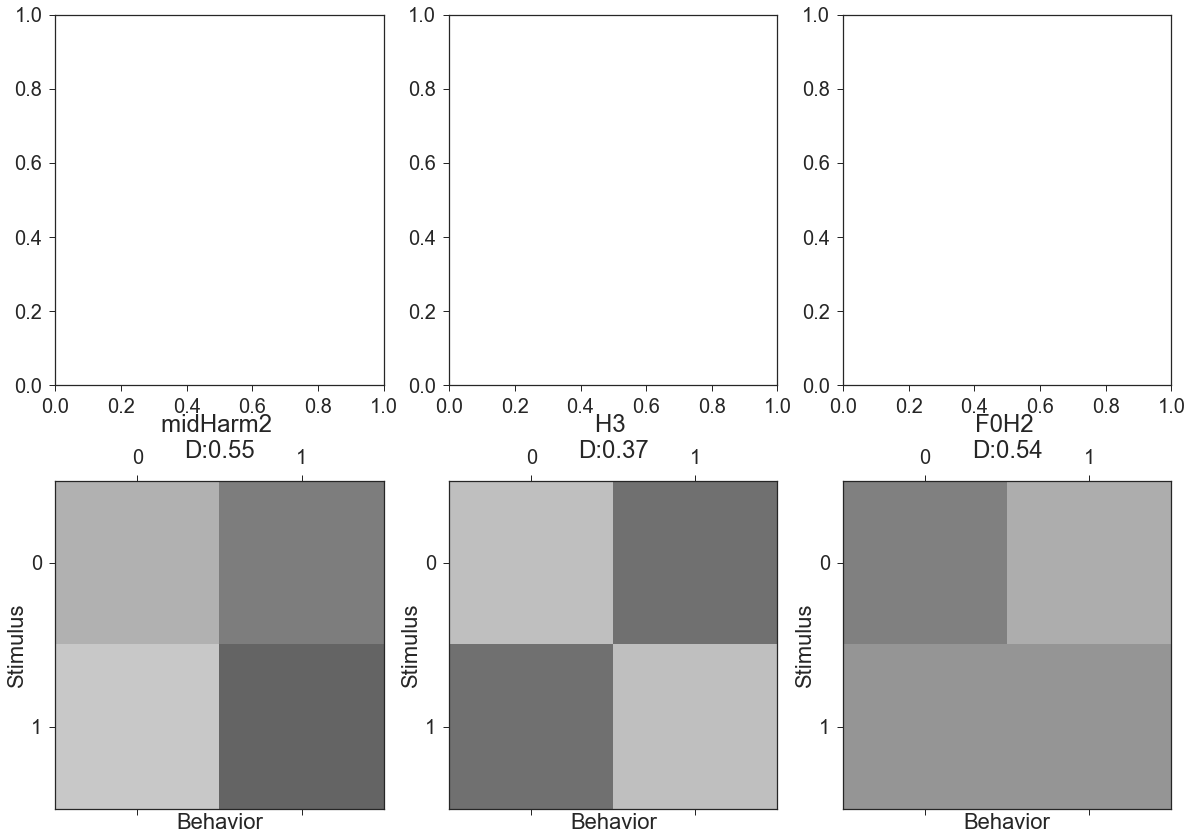

In [15]:
#  trial = ['stim', c, 'stim time', stim_t[idx][idxS], 'hit', hit,
# 'correction trial', corr, 'lickR', RL, 'lickL', LL, 'isTrial',isTrial, 'TrialID', stimID, 'session IDX', idx]

localTrial = []
stimNames = ['allHarm', 'midHarm', 'highHarm', 'midHarm2','H3','F0H2']
         
for n_,t in enumerate(allTrials):
    if t[13]:# is a test trial
        localTrial.append(t)
        
nTrialR = [0, 0, 0, 0, 0, 0]
nTrialL = [0, 0, 0, 0, 0, 0]
hitR = [0, 0, 0, 0, 0, 0]
hitL = [0, 0, 0, 0, 0, 0]
for t_, trial in enumerate(localTrial):
#     print(trial[15])
    if trial[7]: # avoid correction trials
        continue
    if trial[1] == 0: # Right stim
        for s_,sound in enumerate(stimNames):
            if re.search(sound+"$",trial[15]):
#             if sound in trial[15]:
                nTrialR[s_] = nTrialR[s_]+1
                if trial[5]:
                    hitR[s_] = hitR[s_] + 1
        
    else: # Left stim
         for s_,sound in enumerate(stimNames):
            if re.search(sound+"$",trial[15]):
                nTrialL[s_] = nTrialL[s_]+1
                if trial[5]:
                    hitL[s_] = hitL[s_] + 1

f, ax = plt.subplots(2,3,figsize=(20,15))
for st,a in enumerate(f.axes):
    if nTrialL[st] == 0 or nTrialR[st] == 0:
        print("Response Matrix Values " + stimNames[st] + " : ")
        print("No data")
    else:
        respMat = np.matrix([[hitL[st]/nTrialL[st], (nTrialL[st]-hitL[st])/nTrialL[st]],[(nTrialR[st]-hitR[st])/nTrialR[st],hitR[st]/nTrialR[st]]])
        a.matshow(respMat,vmin=0,vmax=1)
        a.set_title(stimNames[st] + " \nD:" + str(round(np.mean(np.diag(respMat)),2)))
        a.set_xlabel("Behavior")
        a.set_ylabel("Stimulus")
        #plt.axis("off")
        print("Response Matrix Values " + stimNames[st] + " : ")
        print(str(respMat))


        MI = calcMI(respMat)
        print
        print("MI value: " + str(MI))

        print
        print("Diag : " + str(np.mean(np.diag(respMat))))
plt.savefig(savePath + Mname + '_ConfMat.pdf')

# Performance in response to test stimuli over time

Number of trials for allHarm: 0
Number of trials for midHarm: 0
Number of trials for highHarm: 0
Number of trials for midHarm2: 77
Number of trials for H3: 73
Number of trials for F0H2: 76


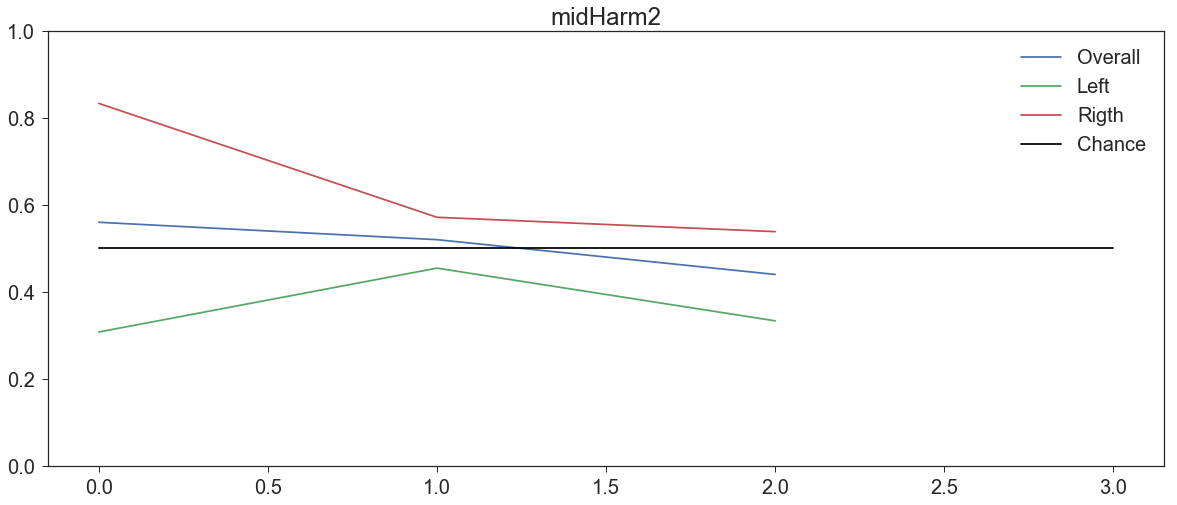

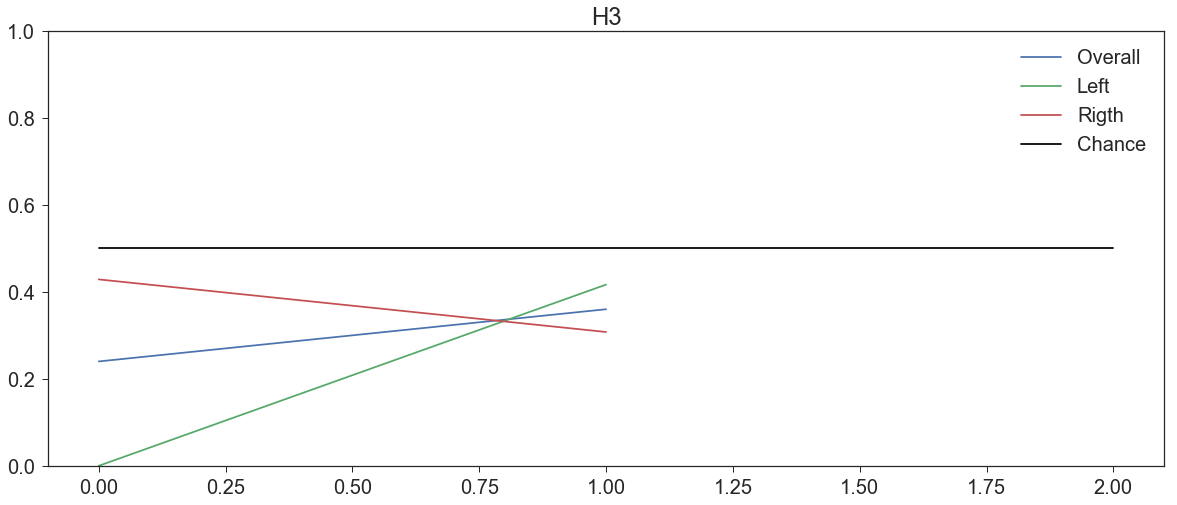

In [16]:
winSize = 25 #time window size, in trial number

stimNames = ['allHarm', 'midHarm', 'highHarm', 'midHarm2','H3','F0H2']
# stimNames = ['allHarm']
   
for s_,stim in enumerate(stimNames):
    localTrial = []
    for n_,t in enumerate(allTrials):
        if t[13] and re.search(stim+"$",t[15]): # is a test trial and stim s is presented
            localTrial.append(t)
    winIdx = 0
    nTrialR = 0; nTrialL = 0; hitR = 0; hitL = 0;
    perf = []
    print("Number of trials for " + stim + ": " + str(len(localTrial)))
    for t_,trial in enumerate(localTrial):
        winIdx = winIdx + 1
        if trial[1] == 0: # Right stim
            nTrialR = nTrialR+1
            if trial[5]:
                hitR = hitR + 1     
        else: # Left stim
            nTrialL = nTrialL+1
            if trial[5]:
                hitL = hitL + 1
        if winIdx == winSize:
            respMat = np.matrix([[hitL/nTrialL, (nTrialL-hitL)/nTrialL],[(nTrialR-hitR)/nTrialR,hitR/nTrialR]])
            plt.figure
#             plt.matshow(respMat,vmin=0,vmax=1)
            MI = calcMI(respMat)
#             d = np.mean(np.diag(respMat))
#             perf.append(np.mean(np.diag(respMat[-1])))
            perf.append([(hitL + hitR) / (nTrialL + nTrialR), (hitL ) / (nTrialL ), (hitR) / (nTrialR)])
#             print(np.mean(np.diag(respMat[-1])))
            winIdx = 0;
            nTrialR = 0; nTrialL = 0; hitR = 0; hitL = 0;
    
    plt.figure(figsize=(20,8))
    plt.plot(range(len(perf)),perf)
    plt.plot([0, len(perf)], [0.5,0.5],color = [0,0,0])
    plt.legend(["Overall","Left","Rigth","Chance"])
    plt.ylim([0,1])
    plt.title(stim)
    
    
#     Number of trials for allHarm: 0
# Number of trials for midHarm: 191
# Number of trials for highHarm: 0
# Number of trials for midHarm2: 191
# Number of trials for H3: 184
# Number of trials for F0H2: 179
